# Analyze TF-MoDISco outputs around variants

In the previous notebook, we computed importances for all variants (both dsQTLs and non-dsQTLs). We performed TF-MoDISco on importance scores at 100 bp around the motif, using the command:

`modisco motifs -s window_100_one_hot.npy -a window_100_attr.npy -n 100000 -o window_100_modisco_results.h5 -w 100 -v`

Now, we can analyze the TF-MoDISco output to see if there's an enrichment of motifs in dsQTLs compared to non-dsQTL variants.

In [1]:
import h5py
import logomaker
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## TF-MoDISco output

In [3]:
modisco_out = h5py.File("./modisco/modisco_report.h5")

In [4]:
modisco_out['pos_patterns'].keys()

<KeysViewHDF5 ['pattern_0', 'pattern_1', 'pattern_2', 'pattern_3']>

In [5]:
MOTIF_LEN = modisco_out['pos_patterns']['pattern_0']['sequence'][:].shape[0]
MOTIF_LEN

30

In [6]:
def trim_pwm_coords(x, threshold=0.4, flank=1):
    # trim at first and last position where no base has prob > threshold
    # x: L x 4

    high_ic = np.where(np.max(x, -1) > threshold)
    return max(0, high_ic[0][0]-flank), min(high_ic[0][-1]+flank, x.shape[0]-1)

In [7]:
from grelu.interpret.motifs import trim_pwm

pattern_0 num_seqlets:832
pattern_1 num_seqlets:604
pattern_2 num_seqlets:238
pattern_3 num_seqlets:69


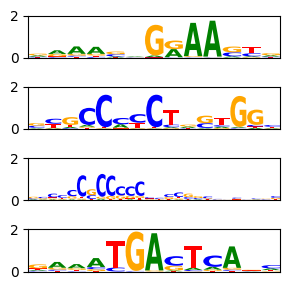

In [8]:
fig, ax = plt.subplots(nrows=len(modisco_out['pos_patterns']), figsize=(3,3))

for i in range(len(modisco_out['pos_patterns'])):
    num_seqlets = modisco_out['pos_patterns'][f'pattern_{i}']['seqlets']['start'].shape[0]
    cur_pwm = modisco_out['pos_patterns'][f'pattern_{i}']['sequence'][:]

    ic_mat = logomaker.transform_matrix(pd.DataFrame(cur_pwm, 
                                                     columns=['A','C','G','T']),
                                        from_type='probability',
                                        to_type='information')
                                        
    trim_start, trim_end = trim_pwm(ic_mat.T, trim_threshold=.1, return_indices=True)
    
    print(f"pattern_{i} num_seqlets:{num_seqlets}")
    logomaker.Logo(ic_mat.iloc[trim_start:trim_end],
                  figsize=(4,1),
                  ax=ax[i])
    ax[i].set_ylim((0,2))
    ax[i].set_yticks([0,2])
    ax[i].set_xticks([])

plt.tight_layout()
plt.savefig("./figures/modisco_motifs.pdf")
    # break

## Variants

In [9]:
# file can be downloaded from https://static-content.springer.com/esm/art%3A10.1038%2Fng.3331/MediaObjects/41588_2015_BFng3331_MOESM26_ESM.xlsx
variants_df = pd.read_csv("/home/nairs51/resources/LCL_dsQTL/41588_2015_BFng3331_MOESM26_ESM.tsv", sep='\t')
variants_df = variants_df[['chrom_hg19', 'pos_hg19', 'allele1', 'allele2', 'label', 'abs_gkm_SVM']]
variants_df = variants_df.set_axis(['chrom', 'pos', 'ref', 'alt', 'label', 'abs_gkm_SVM'], axis=1)
variants_df['label'] = variants_df['label'].replace(-1, 0)

variants_df['start'] = variants_df['pos']
variants_df['end'] = variants_df['start'] + 1

variants_df.head()

,chrom,pos,ref,alt,label,abs_gkm_SVM,start,end
0,chr1,856583,A,G,1,2.653531,856583,856584
1,chr1,911595,G,A,1,2.821422,911595,911596
2,chr1,1186502,T,A,1,7.167236,1186502,1186503
3,chr1,1227412,A,G,1,3.957382,1227412,1227413
4,chr1,1590575,A,G,1,4.785596,1590575,1590576


In [10]:
from grelu.data.preprocess import filter_blacklist, filter_chromosomes, filter_chrom_ends
from grelu.variant import filter_variants

/home/nairs51/miniforge3/envs/grelu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
variants = filter_variants(variants_df, max_del_len=0, max_insert_len=0, standard_bases=True)

Initial number of variants: 28309
Final number of variants: 28309


In [12]:
variants = filter_chromosomes(variants, include='autosomesXY')

Keeping 28309 intervals


In [13]:
ENFORMER_SEQLEN = 196608

In [14]:
variants = filter_chrom_ends(variants, genome='hg19', pad=ENFORMER_SEQLEN//2)

Keeping 28274 intervals


In [15]:
variants['label']

0        1
1        1
2        1
3        1
4        1
        ..
28304    0
28305    0
28306    0
28307    0
28308    0
Name: label, Length: 28274, dtype: int64

In [16]:
Counter(variants['label'])

Counter({0: 27700, 1: 574})

In [17]:
NUM_DSQTL = Counter(variants['label'])[1]
NUM_DSQTL

574

First 574 are dsQTLs and rest are non-dsQTLs. 

## Enrichment

Find all motifs that, after trimming to high IC regions, overlap with the variant. 

In [18]:
seq_idx_with_motif = [] 

for i in range(len(modisco_out['pos_patterns'])):
    cur_motif = modisco_out['pos_patterns'][f'pattern_{i}']
    num_seqlets = cur_motif['seqlets']['start'].shape[0]
    cur_pwm = cur_motif['sequence'][:]
    
    ic_mat = logomaker.transform_matrix(pd.DataFrame(cur_pwm, 
                                                     columns=['A','C','G','T']),
                                        from_type='probability',
                                        to_type='information')
                                        
    trim_start, trim_end = trim_pwm(ic_mat.T, trim_threshold=.1, return_indices=True)

    starts = cur_motif['seqlets']['start'][:]
    ends = cur_motif['seqlets']['end'][:]
    seq_idxs = cur_motif['seqlets']['example_idx'][:]
    is_rc = cur_motif['seqlets']['is_revcomp'][:]

    # modify starts and ends depending on whether motif is revcomp or not in the seq
    starts[~is_rc] += trim_start
    starts[is_rc] += (MOTIF_LEN-trim_end)
    ends[~is_rc] -= (MOTIF_LEN-trim_end)
    ends[is_rc] -= trim_start

    seq_idx_with_motif += list(seq_idxs[(starts<=50)&(ends>50)])

seq_idx_with_motif = np.array(seq_idx_with_motif) 

Since we interleave importances for ref and alt sequences, first 2*NUM_DSQTL indices are from dsQTLs and rest from non-dsQTLs.

We only care about either the ref or alt having a motif, so we will collapse the indices 

In [19]:
variant_idxs_with_motif = np.array(list(set(seq_idx_with_motif//2)))

In [20]:
len(variant_idxs_with_motif)

960

In [21]:
100*((variant_idxs_with_motif<NUM_DSQTL).sum()/NUM_DSQTL)

35.88850174216028

In [22]:
100*((variant_idxs_with_motif>=NUM_DSQTL).sum()/(len(variants)-NUM_DSQTL))

2.7220216606498195

In [23]:
dsqtl_w_motif = (variant_idxs_with_motif<NUM_DSQTL).sum()
dsqtl_wo_motif = NUM_DSQTL - dsqtl_w_motif

non_dsqtl_w_motif = (variant_idxs_with_motif>=NUM_DSQTL).sum()
non_dsqtl_wo_motif = len(variants)-NUM_DSQTL-non_dsqtl_w_motif

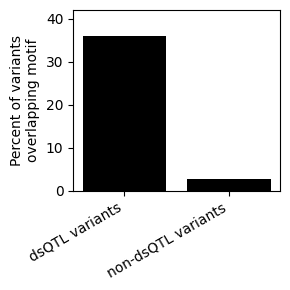

In [24]:
plt.figure(figsize=(3, 3))
plt.bar(x=["dsQTL variants",
          "non-dsQTL variants"],
        height=[100*(dsqtl_w_motif/NUM_DSQTL),
                100*(non_dsqtl_w_motif/(len(variants)-NUM_DSQTL))],
       color='k')
plt.ylabel("Percent of variants\noverlapping motif")
plt.xticks(rotation=30, ha='right')
plt.ylim(0,42)
plt.tight_layout()
# plt.show()
plt.savefig("./figures/modisco_variants.pdf")

In [25]:
import scipy.stats

In [26]:
table = [[dsqtl_w_motif, non_dsqtl_w_motif],
         [dsqtl_wo_motif, non_dsqtl_wo_motif]]

In [27]:
table

[[206, 754], [368, 26946]]

In [28]:
scipy.stats.fisher_exact(table)

SignificanceResult(statistic=20.0051752969669, pvalue=1.8950007177337966e-156)